In [17]:
import numpy as np
import pandas as pd

from etl import *

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split

import lightgbm as lgb
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [18]:
DATA_DIR = './Data/'
DATA_FILE = 'spotify_tracks_kaggle_weekly.csv'
ARTIST_FILE = 'spotify_tracks_artist_details.csv'

In [19]:
data_tracks = pd.read_csv(DATA_DIR + DATA_FILE)
data_artist = pd.read_csv(DATA_DIR + ARTIST_FILE)
data = pd.merge(data_tracks, data_artist, on='track_id', how='left')

In [20]:
RANDOM_STATE = 21
TEST_SIZE = 0.1

In [21]:
X = data.drop('popularity', axis=1)
y = data['popularity']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [23]:
drop_columns = ['track_id', 'artwork_url', 'track_url', 'track_name']

In [24]:
X_train = X_train.drop(drop_columns, axis=1, errors='ignore')
X_test = X_test.drop(drop_columns, axis=1, errors='ignore')

In [25]:
target = 'popularity'

onehot_col = ['language']
circle_of_fifths_col = ['key']
artist_name_col = ['artist_name']
album_name_col = ['album_name']

numeric_columns = list(X_train.columns[X_train.dtypes != object].difference(['key', 'mode']))

nan_columns = ['acousticness', 'danceability', 'energy', 'liveness', 'speechiness', 'tempo', 'valence']

In [26]:
numeric_pipeline = Pipeline(steps=[
    ('imputation', SimpleImputer()),
    ('polynomials', PolynomialFeatures()),
    ('scaling', StandardScaler())
])

artist_name_pipeline = Pipeline(steps=[
    ('encoding', FrequencyEncoder()),
    ('imputation', SimpleImputer()),
    ('scaling', StandardScaler())
])

album_name_pipeline = Pipeline(steps=[
    ('encoding', AlbumNameEncoder()),
    ('imputation', SimpleImputer())
])

circle_of_fifths_pipeline = Pipeline(steps=[
    ('encoding', CircleOfFifthsEncoding()),
    ('imputation', SimpleImputer())
])


transformations = ColumnTransformer(transformers=[
    
    ('onehot_encoding', OneHotEncoder(sparse_output=False), onehot_col),
    ('trigonometric_encoding', circle_of_fifths_pipeline, circle_of_fifths_col),
    ('artist_encoding', artist_name_pipeline, artist_name_col),
    ('album_encoding', album_name_pipeline, album_name_col),
    ('nummeric_processing', numeric_pipeline, numeric_columns)

], remainder='drop').set_output(transform='pandas')


preprocessing = Pipeline(steps=[
    
    ('null_values', ConvertNull(columns=nan_columns)),
    ('transformation', transformations)

]).set_output(transform='pandas')

In [27]:
X_train_preprocessed = preprocessing.fit_transform(X_train)
X_test_preprocessed = preprocessing.fit_transform(X_test)

In [28]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'verbosity': -1,
}

In [29]:
model = lgb.LGBMRegressor(
    random_state=RANDOM_STATE
)

model.fit(X_train_preprocessed, y_train, eval_metric='rmse')

y_pred = model.predict(X_test_preprocessed)
r2_score(y_test, y_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28798
[LightGBM] [Info] Number of data points in the train set: 56085, number of used features: 130
[LightGBM] [Info] Start training from score 15.347865


0.35519957661454415

In [52]:
param_grid = {
    'num_leaves': [31, 63, 127, 255],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.5],
    'max_depth': [-1, 3, 5, 7, 9, 11],
    "subsample": [0.2, 0.8, 1.0],
    "colsample_bytree": [0.2, 0.8, 1.0]
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=0
)

grid.fit(X_train_preprocessed, y_train)
print(f"Best parameters: {grid.best_params_}")
print("Best RMSE:", np.sqrt(-grid.best_score_))

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': -1, 'num_leaves': 255, 'subsample': 0.2}
Best RMSE: 11.942453237466765


In [30]:
model = lgb.LGBMRegressor(
    random_state=RANDOM_STATE,
    colsample_bytree=0.8,
    learning_rate=0.07,
    max_depth=-1,
    num_leaves=255,
    subsample=0.2
)

model.fit(X_train_preprocessed, y_train, eval_metric='rmse')

y_pred = model.predict(X_test_preprocessed)
print('RMSE:', root_mean_squared_error(y_test, y_pred))
print('R^2:', r2_score(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28798
[LightGBM] [Info] Number of data points in the train set: 56085, number of used features: 130
[LightGBM] [Info] Start training from score 15.347865
RMSE: 15.10122790103981
R^2: 0.36053839682026523


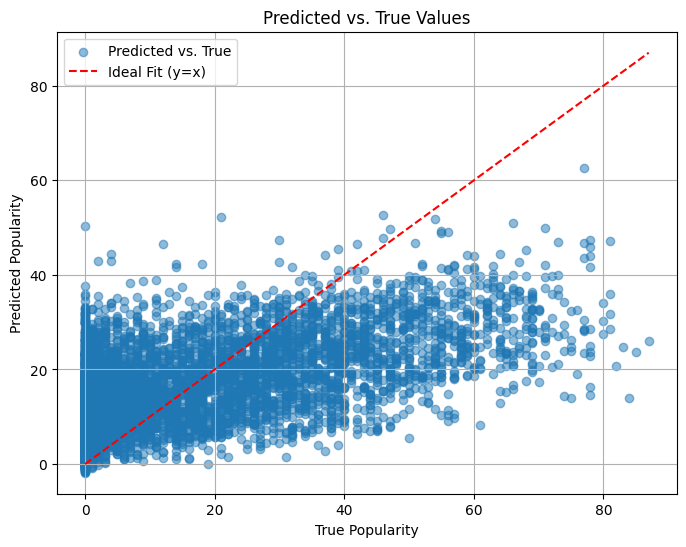

In [31]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs. True')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit (y=x)')
plt.xlabel('True Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Predicted vs. True Values')
plt.legend()
plt.grid()
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28798
[LightGBM] [Info] Number of data points in the train set: 56085, number of used features: 130
[LightGBM] [Info] Start training from score 15.347865


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

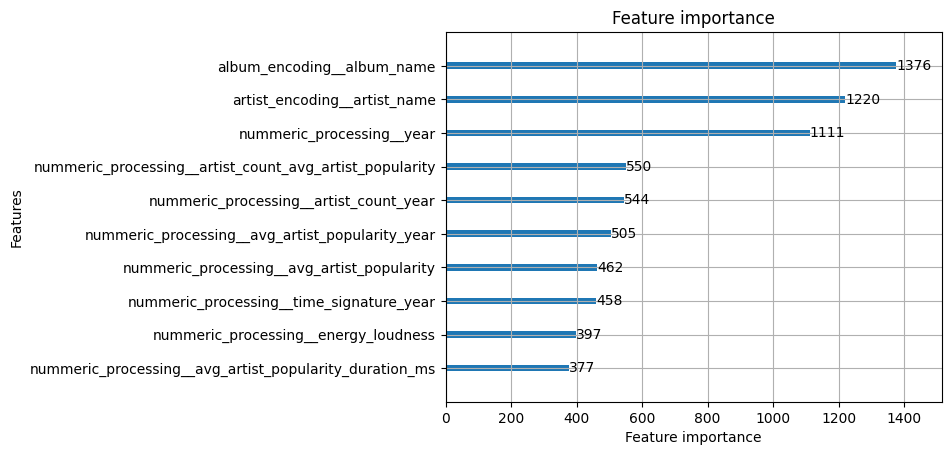

In [32]:
train_data = lgb.Dataset(X_train_preprocessed, label=y_train)
model = lgb.train(
    params={'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': -1, 'num_leaves': 255, 'subsample': 0.2},
    train_set=train_data,
)

lgb.plot_importance(model, max_num_features=10)